
# Bass String/Fret Classifier — Classical ML with **Inharmonicity (β)** + Timbre Features
*A highly commented, practical notebook for real‑time use and JUCE porting*

**What this does**
- Trains a tiny **classical ML** model (RBF‑SVM) to classify the **string** (E=1, A=2, D=3, G=4) from a single bass note,
- Then computes the **fret** from the detected **pitch (f₀)** and predicted string,
- Uses **inharmonicity β** as the most important feature, plus several compact timbre descriptors,
- Designed to be **fast** enough for real‑time visuals in your app/plugin.

**What you’ll learn here**
- Exactly **how the features are computed** and **why** they help,
- How to **train**, **evaluate**, and **sanity‑check** the model,
- How to measure **latency**,
- How to **export** the model parameters for a future **JUCE** C++ implementation.



## How to run this notebook (quick start)
1. Put the IDMT‑SMT‑Bass **.wav** files into `~/bassenv/Dataset` in any of these subfolders: **FS, MU, PK, SP, ST, NO**.  
   (You can change the path later if yours differs.)
2. In JupyterLab, run **Kernel → Restart & Run All** (or run cells top‑to‑bottom).
3. Watch for:
   - A **manifest** table (parsed `string` & `fret`),
   - A **feature** table,
   - **Training results** (accuracy, classification report, confusion matrix),
   - **Permutation importance** plot (which features matter most),
   - **Latency** timing for feature extraction + prediction.

Artifacts saved to `/mnt/data/`:
- `string_svm_inharmonicity.joblib` — full scikit‑learn pipeline (scaler + SVM),
- `feature_scaler.joblib` — the fitted scaler (also included in the pipeline),
- `idmt_manifest.csv`, `idmt_features.csv`,
- `svm_export_for_juce.json` — compact export of support vectors, coefficients, etc. for C++ porting.


In [1]:

from __future__ import annotations

# ------------------------------
# Imports you'll need throughout
# ------------------------------
import os, re, math, json, glob, warnings, time, statistics
import numpy as np
import pandas as pd

# SciPy for audio I/O and some DSP helpers
from scipy.io import wavfile
from scipy.signal import get_window, resample_poly

# Scikit-learn for the classical ML pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

import joblib
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['figure.figsize'] = (7,5)

# ------------------------------------
# Paths — defaults to your 'bassenv'
# ------------------------------------
# Put your dataset here: ~/bassenv/Dataset/{FS,MU,PK,SP,ST,NO}/...wav
DATASET_DIR = os.path.expanduser(r"C:\Users\levon\Desktop\Jupyter\bassenv\Dataset(PS+NO)")  # <-- Change if your dataset lives elsewhere
SAVE_DIR     = r"C:\Users\levon\Desktop\Jupyter\bassenv\mnt\data"  # Where we'll drop models/CSVs/exports

# Files we'll write for you
MODEL_PATH     = os.path.join(SAVE_DIR, "string_svm_inharmonicity.joblib")
SCALER_PATH    = os.path.join(SAVE_DIR, "feature_scaler.joblib")
MANIFEST_PATH  = os.path.join(SAVE_DIR, "idmt_manifest.csv")
FEATS_PATH     = os.path.join(SAVE_DIR, "idmt_features.csv")
EXPORT_JSON    = os.path.join(SAVE_DIR, "svm_export_for_juce.json")

# Only include these top-level subfolders (as requested)
ALLOWED_TOP_SUBFOLDERS = {"FS", "MU", "PK", "SP", "ST", "NO"}

print("DATASET_DIR =", DATASET_DIR)
print("Allowed subfolders:", sorted(ALLOWED_TOP_SUBFOLDERS))
print("Saving artifacts under:", SAVE_DIR)


DATASET_DIR = C:\Users\levon\Desktop\Jupyter\bassenv\Dataset(PS+NO)
Allowed subfolders: ['FS', 'MU', 'NO', 'PK', 'SP', 'ST']
Saving artifacts under: C:\Users\levon\Desktop\Jupyter\bassenv\mnt\data


In [2]:

# --------------------------------------------------
# Musical basics we rely on (standard 4-string bass)
# --------------------------------------------------
# We assume standard tuning (E1 A1 D2 G2) and A4 = 440 Hz.
# These open-string frequencies let us compute the expected pitch on any fret.
OPEN_STRING_FREQ = {
    1: 41.2034,  # E1
    2: 55.0000,  # A1
    3: 73.4162,  # D2
    4: 97.9989,  # G2
}

def freq_from_string_fret(string_num: int, fret: int) -> float:
    """Given a string number (1=E, 4=G) and fret, return the theoretical f0 in Hz.
    Formula: f_fret = f_open * 2^(fret/12)."""
    return OPEN_STRING_FREQ[int(string_num)] * (2 ** (fret / 12.0))

def fret_from_freq_and_string(f0: float, string_num: int, max_fret: int = 24) -> int:
    """Given a measured f0 and a predicted string, estimate the closest fret.
    We clamp to 0..max_fret to avoid out-of-range values."""
    f_open = OPEN_STRING_FREQ[int(string_num)]
    est = int(round(12.0 * math.log2(max(f0, 1e-9) / f_open)))
    return max(0, min(max_fret, est))


In [3]:

# -----------------------------------------------------------------------
# Filename parsing — robust to your described pattern + older IDMT names
# -----------------------------------------------------------------------
# New naming (from your doc):
#   BS_[k]_EQ_[m]_[PluckingStyle]_[ExpressionStyle]_[StringNumber]_[FretNumber].wav
# Strategy: take the last TWO underscore-separated numeric tokens as (string, fret).
def parse_new_style_filename(path: str):
    name = os.path.splitext(os.path.basename(path))[0]
    tokens = name.split("_")
    nums = [int(tok) for tok in tokens if tok.isdigit()]
    if len(nums) >= 2:
        string_num, fret = nums[-2], nums[-1]
        # Sanity: 1..4 strings; frets in a plausible range (0..30 gives us headroom)
        if 1 <= string_num <= 4 and 0 <= fret <= 30:
            return {"string": int(string_num), "fret": int(fret)}
    return None

# Fallback regexes you might encounter in other IDMT dumps:
PATTERNS = [
    re.compile(r"[sS](?P<string>[1-4]).*?[fF](?:ret|rt)?(?P<fret>\d{1,2})"),
    re.compile(r"[sS]tr(?:ing)?(?P<string>[1-4]).*?[fF](?:ret|rt)?(?P<fret>\d{1,2})"),
    re.compile(r"[fF](?:ret|rt)?(?P<fret>\d{1,2}).*?[sS](?P<string>[1-4])"),
]

def parse_fallback_patterns(path: str):
    name = os.path.basename(path)
    for pat in PATTERNS:
        m = pat.search(name)
        if m:
            string_num = int(m.group("string"))
            fret = int(m.group("fret"))
            return {"string": string_num, "fret": fret}
    return None

def parse_idmt_filename(path: str):
    """Try the new style first, then fall back to legacy regexes.
    If nothing matches, return None and we'll skip that file."""
    out = parse_new_style_filename(path)
    if out is not None:
        return out
    return parse_fallback_patterns(path)


In [4]:

# ---------------------------------------
# Audio loading and careful resampling
# ---------------------------------------
def load_wav_mono(path: str, target_sr: int = 44100):
    """Load a WAV file, convert to mono float32 in [-1,1], and resample if needed.
    Why resample? Consistent sample rate simplifies FFT bin math and feature extraction."""
    sr, x = wavfile.read(path)
    # Convert integer PCM to float
    if x.dtype == np.int16:
        x = x.astype(np.float32) / 32768.0
    elif x.dtype == np.int32:
        x = x.astype(np.float32) / 2147483648.0
    elif x.dtype == np.uint8:
        x = (x.astype(np.float32) - 128) / 128.0
    else:
        x = x.astype(np.float32)
    # Downmix to mono if needed
    if x.ndim == 2:
        x = x.mean(axis=1)
    # High-quality rational resampling to target_sr
    if sr != target_sr:
        from math import gcd
        g = gcd(sr, target_sr)
        up = target_sr // g
        down = sr // g
        x = resample_poly(x, up, down).astype(np.float32)
        sr = target_sr
    return x, sr


In [5]:

# --------------------------------------------------
# A compact f0 estimator (YIN-like CMNDF variant)
# --------------------------------------------------
# Why do we need f0?
# - The fret is computed from f0 + predicted string.
# - f0 also helps the feature extractor know where harmonics should be.
def estimate_f0_yin(x, sr, fmin=30.0, fmax=400.0):
    """Very small, dependency-free f0 estimator good enough for clean isolated notes.
    It computes a Yin-like normalized difference and picks the first dip below a threshold,
    with a bit of parabolic interpolation for sub-bin precision."""
    x = np.asarray(x, dtype=np.float32)
    N = len(x)
    if N < int(sr*0.02):  # Need at least ~20 ms to be sane
        return 0.0
    x = x - np.mean(x)
    x = x * np.hanning(N)  # reduce spectral leakage
    max_tau = int(sr / fmin)
    min_tau = int(sr / fmax)
    # Difference function (naive; fast enough for short windows)
    x2 = np.append(x, np.zeros(max_tau, dtype=np.float32))
    d = np.zeros(max_tau+1, dtype=np.float64)
    for tau in range(1, max_tau+1):
        d[tau] = np.sum((x2[:N] - x2[tau:tau+N])**2)
    # Cumulative mean normalized difference function (CMNDF)
    cmndf = np.zeros_like(d)
    cmndf[1:] = d[1:] * np.arange(1, len(d)) / np.cumsum(d[1:])
    # Find candidate period
    thresh = 0.1
    idx = np.where((cmndf[min_tau:] < thresh))[0]
    tau = int(np.argmin(cmndf[min_tau:]) + min_tau) if len(idx)==0 else int(idx[0] + min_tau)
    # Parabolic refine around tau for sub-sample period
    if 1 < tau < len(cmndf)-1:
        a, b, c = cmndf[tau-1], cmndf[tau], cmndf[tau+1]
        denom = (a - 2*b + c) + 1e-12
        p = 0.5*(a - c)/denom
        tau = tau + p
    f0 = sr / max(tau, 1e-6)
    return float(f0)


In [6]:

# --------------------------------------------------------------
# Harmonic tracking + inharmonicity (β) and extra descriptors
# --------------------------------------------------------------
# Key idea: A real string is slightly "stiff" -> harmonics are a bit sharp.
# That deviation from perfect n*f0 can be summarized by β, which varies by
# string gauge, length, and fret. It's a powerful cue for which string/fret.
def _quadratic_interp(mag, k):
    """Parabolic interpolation around bin k — gives sub-bin peak location/magnitude."""
    if k <= 0 or k >= len(mag)-1:
        return float(k), float(mag[k])
    a, b, c = mag[k-1], mag[k], mag[k+1]
    denom = (a - 2*b + c)
    if abs(denom) < 1e-12:
        return float(k), float(b)
    delta = 0.5*(a - c)/denom
    peak_mag = b - 0.25*(a - c)*delta
    return float(k + delta), float(peak_mag)

def track_harmonics_and_beta(x, sr, f0, n_harm=6, start_ms=50, win_ms=70, zero_pad=4):
    """Measure harmonic frequencies/amps in a short sustain window and estimate β.
    Why a sustain window? Right after the attack, partials are cleaner and more stable.
    - n_harm: how many partials we attempt to track (6 is a good tradeoff)
    - start_ms/win_ms: choose a short window well after the attack for stability"""
    # Pick analysis frame in (post-attack) sustain
    start = int(sr * (start_ms/1000.0))
    win = int(sr * (win_ms/1000.0))
    if start + win > len(x):
        start = max(0, len(x) - win)
    frame = x[start:start+win].copy()
    frame *= get_window("hann", len(frame), fftbins=True)

    # FFT with zero-padding for better peak interpolation resolution
    N = 1
    while N < len(frame):
        N <<= 1
    N *= zero_pad
    spec = np.fft.rfft(frame, n=N)
    mag  = np.abs(spec)
    freqs = np.fft.rfftfreq(N, 1/sr)
    bin_hz = sr / N

    # Two light-weight spectral shape descriptors
    psd = mag**2 + 1e-12
    centroid = float(np.sum(freqs * psd)/np.sum(psd))   # "brightness"
    geo = float(np.exp(np.mean(np.log(mag + 1e-12))))   # geometric mean
    ari = float(np.mean(mag + 1e-12))                   # arithmetic mean
    flatness = float(geo/ari)                           # "tonal vs noise-like"

    # Track peaks near expected n * f0, with small local search + parabolic refine
    harmonic_freqs, harmonic_amps = [], []
    for n in range(1, n_harm+1):
        target = n * f0
        if target <= 0 or target >= sr/2 - 5:
            harmonic_freqs.append(np.nan)
            harmonic_amps.append(0.0)
            continue
        k = int(round(target / bin_hz))
        k = max(1, min(k, len(mag)-2))
        # New: dynamic width based on frequency (still very cheap)
        search_bins = max(3, int(round(2 + 0.01 * (target / bin_hz))))
        k0, k1 = max(1, k - search_bins), min(len(mag)-2, k + search_bins)
        loc = int(np.argmax(mag[k0:k1+1]) + k0)
        peak_bin, peak_mag = _quadratic_interp(mag, loc)
        harmonic_freqs.append(float(peak_bin * bin_hz))
        harmonic_amps.append(float(peak_mag))

    # β via weighted least squares on: (f_n/(n f0))^2 = 1 + β n^2
    ratios2, weights, ns = [], [], []
    for n, fn, amp in zip(range(1, n_harm+1), harmonic_freqs, harmonic_amps):
        if not np.isnan(fn) and fn > 0 and f0 > 0:
            ratios2.append((fn/(n*f0))**2)
            ns.append(n)
            weights.append(max(amp, 1e-6))
    if len(ratios2) >= 2:
        ns = np.asarray(ns, dtype=float)
        y = np.asarray(ratios2, dtype=float) - 1.0
        X = (ns**2)[:, None]
        W = np.diag(np.asarray(weights, dtype=float) / (max(weights) if weights else 1.0))
        beta = float(np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y))
        beta = max(beta, 0.0)  # physical (no negative stiffness)
    else:
        beta = 0.0

    # Residual stretch statistics: how far measured peaks deviate from the β model
    residuals = []
    for n, fn in zip(range(1, n_harm+1), harmonic_freqs):
        if not np.isnan(fn) and fn > 0 and f0 > 0:
            pred = n*f0*np.sqrt(1.0 + beta*(n**2))
            residuals.append((fn - pred)/(pred + 1e-9))
    resid_mean = float(np.mean(residuals)) if residuals else 0.0
    resid_std  = float(np.std(residuals))  if residuals else 0.0

    # Odd/even harmonic energy ratio — useful timbre cue (pickups, string, playing)
    odd  = sum(a for i,a in enumerate(harmonic_amps, start=1) if i % 2 == 1)
    even = sum(a for i,a in enumerate(harmonic_amps, start=1) if i % 2 == 0) + 1e-9
    odd_even_ratio = float(odd/even)

    return dict(beta=beta,
                harmonic_freqs=harmonic_freqs, harmonic_amps=harmonic_amps,
                resid_mean=resid_mean, resid_std=resid_std,
                centroid=centroid, flatness=flatness, odd_even_ratio=odd_even_ratio)


In [7]:

# ------------------------------------
# Feature vector (compact but telling)
# ------------------------------------
# We keep this SMALL (≈11 numbers) for speed + portability.
# β is the star feature; the rest stabilize classification across strings/frets.
FEATURES = [
    "beta",
    "a2_over_a1_log","a3_over_a1_log","a4_over_a1_log","a5_over_a1_log","a6_over_a1_log",
    "resid_mean","resid_std",
    "centroid","flatness","odd_even_ratio",
    "f0",
]

EPS = 1e-8

def _safe_log_ratio(Ak, A1, eps=EPS):
    # If either amplitude is tiny/missing, return NaN so the imputer can fill it
    if A1 <= eps or Ak <= eps or not np.isfinite(Ak) or not np.isfinite(A1):
        return np.nan
    return float(np.log10(Ak / A1))

def build_feature_row(x, sr, f0, n_harm=6):
    m = track_harmonics_and_beta(x, sr, f0, n_harm=n_harm)
    amps = np.array(m["harmonic_amps"], dtype=float)

    # ---- Cap usable harmonics by Nyquist ----
    # If k*f0 exceeds Nyquist, that harmonic isn't measurable.
    if f0 <= 0:
        n_harm_valid = 1
    else:
        nyq = sr / 2.0
        margin_hz = 10.0  # small safety margin
        max_h_by_nyq = int(np.floor((nyq - margin_hz) / max(f0, 1e-9)))
        n_harm_valid = int(np.clip(max_h_by_nyq, 1, n_harm))

    # First harmonic amplitude (A1)
    A1 = amps[0] if len(amps) > 0 else 0.0

    # Build up to 5 log-ratios: A2/A1 ... A6/A1 (use NaN when not valid)
    ratios = []
    for k in range(2, 7):  # 2..6
        if (k <= n_harm_valid) and (k-1 < len(amps)):
            ratios.append(_safe_log_ratio(amps[k-1], A1))
        else:
            ratios.append(np.nan)

    return dict(
        beta=float(m["beta"]),
        a2_over_a1_log=ratios[0],
        a3_over_a1_log=ratios[1],
        a4_over_a1_log=ratios[2],
        a5_over_a1_log=ratios[3],
        a6_over_a1_log=ratios[4],
        resid_mean=float(m["resid_mean"]),
        resid_std=float(m["resid_std"]),
        centroid=float(m["centroid"]),
        flatness=float(m["flatness"]),
        odd_even_ratio=float(m["odd_even_ratio"]),
        f0=float(f0),
    )



In [8]:

# ---------------------------
# Build a dataset manifest
# ---------------------------
# We recurse through only the six requested top-level folders and parse labels
# from each filename. If we can't parse a file, we skip it (and print a hint).
def build_manifest(dataset_dir: str, limit: int|None = None) -> pd.DataFrame:
    files = []
    for sub in sorted(ALLOWED_TOP_SUBFOLDERS):
        subdir = os.path.join(dataset_dir, sub)
        if os.path.isdir(subdir):
            files.extend(glob.glob(os.path.join(subdir, "**", "*.wav"), recursive=True))

    if limit:
        files = files[:limit]

    rows, skipped = [], 0
    for path in files:
        info = parse_idmt_filename(path)
        if info is None:
            skipped += 1
            continue
        row = dict(path=path, string=int(info["string"]), fret=int(info["fret"]))
        # IDMT is standard tuning; we can compute the theoretical f0 label
        row["f0_label"] = float(freq_from_string_fret(row["string"], row["fret"]))
        rows.append(row)

    if skipped:
        print(f"Skipped {skipped} files that didn't parse — adjust the parser if needed.")
    return pd.DataFrame(rows)

# Create (or refresh) the manifest
if os.path.isdir(DATASET_DIR):
    df_manifest = build_manifest(DATASET_DIR)
    print(f"Found {len(df_manifest)} labeled files across allowed subfolders.")
    if len(df_manifest) > 0:
        display(df_manifest.sample(min(5, len(df_manifest))))
        df_manifest.to_csv(MANIFEST_PATH, index=False)
        print("Manifest saved to:", MANIFEST_PATH)
else:
    df_manifest = pd.DataFrame()
    print("⚠️ DATASET_DIR not found:", DATASET_DIR)


Skipped 3 files that didn't parse — adjust the parser if needed.
Found 2808 labeled files across allowed subfolders.


,path,string,fret,f0_label
1399,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,4,5,130.812837
426,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,1,7,61.735346
103,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,4,9,164.813847
2329,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,4,10,174.614189
2489,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,4,3,116.540989


Manifest saved to: C:\Users\levon\Desktop\Jupyter\bassenv\mnt\data\idmt_manifest.csv


In [9]:

# ---------------------------------
# Feature extraction over manifest
# ---------------------------------
def estimate_note_f0_for_training(x, sr, detect_window_sec=0.30):
    """We estimate f0 from the first ~300 ms (still in note onset/sustain)."""
    N = int(min(len(x), sr*detect_window_sec))
    return estimate_f0_yin(x[:N], sr)

def extract_features_from_manifest(df: pd.DataFrame, use_label_f0=True) -> pd.DataFrame:
    """Turn every labeled file into a single feature row.
    use_label_f0=True means we trust the theoretical f0 (from string/fret).
    Later, you can set it False to see how robust you are to f0 estimation error."""
    rows = []
    for _, row in df.iterrows():
        x, sr = load_wav_mono(row["path"], target_sr=44100)
        f0 = float(row["f0_label"]) if use_label_f0 else float(estimate_note_f0_for_training(x, sr))
        if f0 <= 0:
            continue
        feats = build_feature_row(x, sr, f0, n_harm=6)
        feats.update(dict(
            path=row["path"],
            string=int(row["string"]),
            fret=int(row["fret"]),
            f0_label=float(row["f0_label"]),
        ))
        rows.append(feats)
    return pd.DataFrame(rows)

if not df_manifest.empty:
    print("Extracting features (first run may take a few minutes)...")
    df_feats = extract_features_from_manifest(df_manifest, use_label_f0=True)
    print(f"Got {len(df_feats)} feature rows.")
    if len(df_feats):
        display(df_feats.head())
        df_feats.to_csv(FEATS_PATH, index=False)
        print("Saved features to:", FEATS_PATH)
    df_feats = df_feats.replace([np.inf, -np.inf], np.nan)
    print("NaN count per feature:\n", df_feats[FEATURES].isna().sum())
else:
    df_feats = pd.DataFrame()
    print("No manifest; skipping feature extraction.")


Extracting features (first run may take a few minutes)...


C:\Users\levon\AppData\Local\Temp\ipykernel_41228\2447059890.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = float(np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y))


Got 2808 feature rows.


,beta,a2_over_a1_log,a3_over_a1_log,a4_over_a1_log,a5_over_a1_log,a6_over_a1_log,resid_mean,resid_std,centroid,flatness,odd_even_ratio,f0,path,string,fret,f0_label
0,0.000000,-0.251221,-1.017648,-0.601591,-1.525056,-0.768858,-0.077751,0.134358,83.900758,0.488967,1.147317,41.203400,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,1,0,41.203400
1,0.006671,-0.393216,-0.265281,-1.062653,-0.469151,-0.929825,0.021765,0.096862,160.855014,0.361097,3.093635,43.653482,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,1,1,43.653482
2,0.002316,0.227659,0.290029,-0.664522,-0.250525,-0.323463,0.004678,0.080809,95.929295,0.245648,1.475198,73.416112,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,1,10,73.416112
3,0.078346,-1.374787,-1.673567,-0.714623,-1.369794,-1.711041,0.057933,0.833061,56.776640,0.243787,4.179265,77.781662,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,1,11,77.781662
4,0.000000,-0.135887,NaN,-0.557747,-0.204971,-1.011154,0.024614,0.113290,181.346848,0.262461,0.152590,82.406800,C:\Users\levon\Desktop\Jupyter\bassenv\Dataset...,1,12,82.406800


Saved features to: C:\Users\levon\Desktop\Jupyter\bassenv\mnt\data\idmt_features.csv
NaN count per feature:
 beta                0
a2_over_a1_log    449
a3_over_a1_log    461
a4_over_a1_log    444
a5_over_a1_log    439
a6_over_a1_log    422
resid_mean          0
resid_std           0
centroid            0
flatness            0
odd_even_ratio      0
f0                  0
dtype: int64


In [10]:
import numpy as np

def clean_features(df):
    # Replace inf with NaN, then drop rows that still have NaN in model features/labels
    df = df.replace([np.inf, -np.inf], np.nan)
    before = len(df)
    df = df.dropna(subset=FEATURES + ["string"])
    dropped = before - len(df)
    print(f"Dropped {dropped} rows with NaN/Inf features.")
    return df

# (Optional) quick debug to see where NaNs are
if len(df_feats):
    print("NaN count per feature:\n", df_feats[FEATURES].isna().sum())

df_feats = clean_features(df_feats)


NaN count per feature:
 beta                0
a2_over_a1_log    449
a3_over_a1_log    461
a4_over_a1_log    444
a5_over_a1_log    439
a6_over_a1_log    422
resid_mean          0
resid_std           0
centroid            0
flatness            0
odd_even_ratio      0
f0                  0
dtype: int64
Dropped 1076 rows with NaN/Inf features.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'svm__C': 4, 'svm__gamma': 0.1}

Held-out test accuracy: 0.6195965417867435

Classification report:
               precision    recall  f1-score   support

           1      0.728     0.753     0.740        89
           2      0.461     0.566     0.508        83
           3      0.562     0.461     0.506        89
           4      0.750     0.698     0.723        86

    accuracy                          0.620       347
   macro avg      0.625     0.619     0.619       347
weighted avg      0.627     0.620     0.620       347



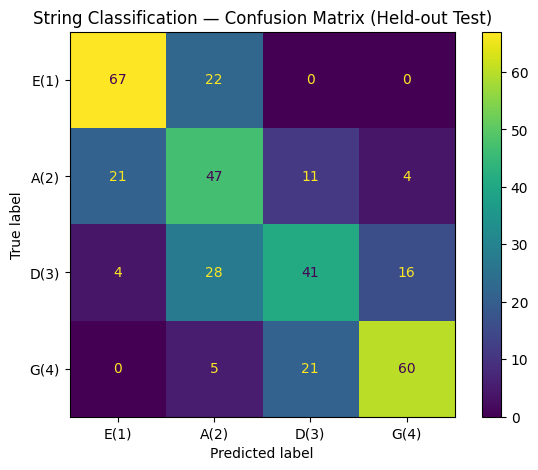

5-fold CV accuracy: mean=0.602  std=0.026
Per-fold: ['0.565', '0.614', '0.578', '0.636', '0.616']

Saved model to: C:\Users\levon\Desktop\Jupyter\bassenv\mnt\data\string_svm_inharmonicity.joblib


In [11]:

# ---------------------------------------------
# Train a tiny string classifier (SVM + scaler)
# ---------------------------------------------
# Why SVM?
# - With a small, well-shaped feature vector, SVMs are fast and strong.
# - RBF kernel handles mild non-linear boundaries without a large model.
# - Scikit-learn SVC uses libsvm under the hood (there are C/C++ ports).

def train_string_classifier(df_feats: pd.DataFrame):
    # 1) Split once for a held-out test, stratified to preserve class ratios
    X = df_feats[FEATURES].values
    y = df_feats["string"].values

    # Always scale before an RBF SVM; it matters a lot for distance-based kernels
    pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),  # NEW: fill NaNs feature-wise
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced")),
    ])


    # 2) Small grid search (kept compact for speed)
    param_grid = {
        "svm__C":    [0.5, 1, 2, 4],
        "svm__gamma": ["scale", 0.5, 0.25, 0.1],
    }
    # One split for final test; CV inside the search keeps it honest
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    print("Best params:", gs.best_params_)

    # 3) Evaluation on held-out test set
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("\nHeld-out test accuracy:", acc)
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['E(1)','A(2)','D(3)','G(4)']).plot(values_format='d')
    plt.title("String Classification — Confusion Matrix (Held-out Test)")
    plt.show()

    # 4) Quick sanity cross-val score on the whole dataset (to see variance)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(best, X, y, cv=skf, n_jobs=-1)
    print(f"5-fold CV accuracy: mean={cv_scores.mean():.3f}  std={cv_scores.std():.3f}")
    print("Per-fold:", [f"{s:.3f}" for s in cv_scores])

    # 5) Save model + scaler
    joblib.dump(best, MODEL_PATH)
    joblib.dump(best.named_steps["scaler"], SCALER_PATH)
    print("\nSaved model to:", MODEL_PATH)

    return best, (X_test, y_test)

if not df_feats.empty:
    model, test_split = train_string_classifier(df_feats)
else:
    model, test_split = None, (None, None)
    print("No features; skipping training.")


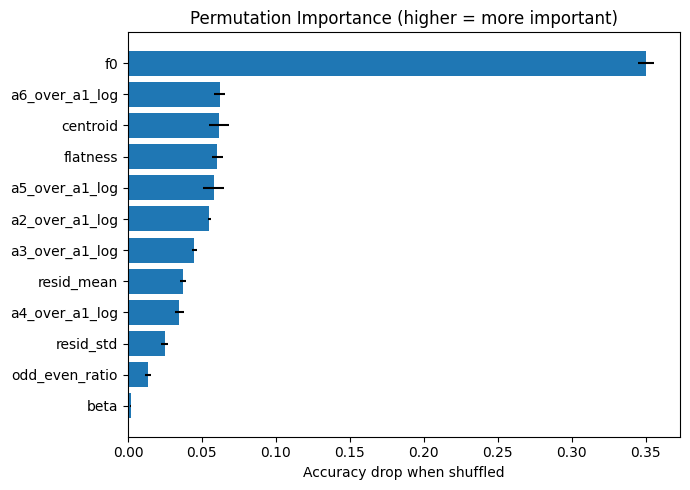

,feature,importance_mean,importance_std
11,f0,0.350115,0.005312
5,a6_over_a1_log,0.062009,0.003892
8,centroid,0.061432,0.006629
9,flatness,0.060277,0.003663
4,a5_over_a1_log,0.057852,0.007298
1,a2_over_a1_log,0.054850,0.001033
2,a3_over_a1_log,0.044688,0.001657
6,resid_mean,0.037413,0.001911
3,a4_over_a1_log,0.034642,0.002989
7,resid_std,0.024827,0.002450


In [12]:

# ---------------------------------------------
# Which features matter? (Permutation importance)
# ---------------------------------------------
# This is slow-ish but insightful: it shuffles one feature at a time and
# measures the drop in accuracy. Bigger drop -> more important in practice.
if model is not None:
    X = df_feats[FEATURES].values
    y = df_feats["string"].values

    r = permutation_importance(model, X, y, scoring="accuracy", n_repeats=5, random_state=0, n_jobs=-1)
    importances = pd.DataFrame({
        "feature": FEATURES,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std,
    }).sort_values("importance_mean", ascending=True)

    # Plot (one plot, default style)
    plt.figure()
    plt.barh(importances["feature"], importances["importance_mean"], xerr=importances["importance_std"])
    plt.xlabel("Accuracy drop when shuffled")
    plt.title("Permutation Importance (higher = more important)")
    plt.tight_layout()
    plt.show()

    display(importances.sort_values("importance_mean", ascending=False))


In [13]:

# ------------------------
# Latency sanity check
# ------------------------
# Measure time for: f0 estimation, feature extraction, and prediction on a single note.
def latency_check_one_example(df_feats: pd.DataFrame, model, n_trials=5):
    sample = df_feats.sample(1, random_state=0).iloc[0]
    x, sr = load_wav_mono(sample["path"], target_sr=44100)

    # Use a shorter segment to mimic real-time note capture
    N = int(min(len(x), sr*0.35))
    x_seg = x[:N]

    t_f0, t_feat, t_pred = [], [], []
    for _ in range(n_trials):
        t0 = time.time()
        f0 = estimate_f0_yin(x_seg, sr)
        t_f0.append((time.time()-t0)*1000.0)  # ms

        t1 = time.time()
        feats = build_feature_row(x_seg, sr, f0)
        X = np.array([[feats[k] for k in FEATURES]], dtype=float)
        t_feat.append((time.time()-t1)*1000.0)

        t2 = time.time()
        _ = model.predict(X)
        t_pred.append((time.time()-t2)*1000.0)

    print("Latency over", n_trials, "trials (ms):")
    print(f"  f0 estimate : mean={statistics.mean(t_f0):.2f}  min={min(t_f0):.2f}  max={max(t_f0):.2f}")
    print(f"  features    : mean={statistics.mean(t_feat):.2f}  min={min(t_feat):.2f}  max={max(t_feat):.2f}")
    print(f"  prediction  : mean={statistics.mean(t_pred):.2f}  min={min(t_pred):.2f}  max={max(t_pred):.2f}")
    print("Total (approx mean):", f"{statistics.mean(t_f0)+statistics.mean(t_feat)+statistics.mean(t_pred):.2f}", "ms")

if model is not None and len(df_feats):
    latency_check_one_example(df_feats, model, n_trials=5)


Latency over 5 trials (ms):
  f0 estimate : mean=24.91  min=24.17  max=25.58
  features    : mean=0.85  min=0.77  max=1.00
  prediction  : mean=0.67  min=0.56  max=0.86
Total (approx mean): 26.43 ms


C:\Users\levon\AppData\Local\Temp\ipykernel_41228\2447059890.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = float(np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y))
C:\Users\levon\AppData\Local\Temp\ipykernel_41228\2447059890.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = float(np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ y))
C:\Users\levon\AppData\Local\Temp\ipykernel_41228\2447059890.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = floa

In [14]:

# --------------------------------------------------
# Real-time inference helper (for your application)
# --------------------------------------------------
class RealTimeStringFretEstimator:
    """Tiny helper you can mirror in C++.
    Steps:
      1) Capture ~80 ms of post-attack sustain,
      2) Estimate f0,
      3) Extract features,
      4) Run SVM to get string,
      5) Compute fret from (f0, string)."""
    def __init__(self, model_path=MODEL_PATH):
        self.model  = joblib.load(model_path)
        self.scaler = self.model.named_steps["scaler"]
        self.svm    = self.model.named_steps["svm"]

    def predict_from_note(self, x, sr, known_f0=None):
        # If you already have a good f0 (e.g., from your DSP), pass it in.
        if known_f0 is None:
            N = int(min(len(x), sr*0.30))
            f0 = estimate_f0_yin(x[:N], sr)
        else:
            f0 = float(known_f0)

        feats = build_feature_row(x, sr, f0)
        X = np.array([[feats[k] for k in FEATURES]], dtype=float)
        y_proba = self.model.predict_proba(X)[0]
        y_pred  = int(self.model.predict(X)[0])
        fret    = fret_from_freq_and_string(f0, y_pred)
        return dict(f0=float(f0), features=feats, string_pred=y_pred,
                    string_probs=y_proba.tolist(), fret_est=int(fret))

# # Smoke test (uncomment after training):
# manifest = pd.read_csv(MANIFEST_PATH) if os.path.exists(MANIFEST_PATH) else None
# if manifest is not None and len(manifest):
#     x, sr = load_wav_mono(manifest.iloc[0]["path"], target_sr=44100)
#     est = RealTimeStringFretEstimator(MODEL_PATH)
#     out = est.predict_from_note(x, sr)
#     print(json.dumps(out, indent=2))


In [15]:

# ------------------------------------------------
# Export model params for a future JUCE C++ port
# ------------------------------------------------
# Scikit-learn's SVC (probability=True) uses LIBSVM with one-vs-one (OvO).
# To re-implement in C++:
#  - Keep the same StandardScaler (mean, scale per feature),
#  - Use RBF kernel K(x,z)=exp(-gamma * ||x - z||^2),
#  - For OvO pairs (i,j): decision = sum_k alpha_k * y_k * K(x, sv_k) + b_ij,
#    where support vectors/dual_coefs/intercepts are exported below.
#  - For probabilities, sklearn does Platt scaling per pair + a coupling step
#    (you can skip probability for v1 and use argmax of decision votes).

def export_svm_for_juce(model, features: list[str], out_json_path: str):
    pipe = model
    scaler = pipe.named_steps["scaler"]
    svm    = pipe.named_steps["svm"]

    # Resolve the effective gamma used by the fitted SVM
    gamma_param = getattr(svm, "_gamma", svm.gamma)
    if isinstance(gamma_param, str):  # e.g., "scale" (shouldn't happen after fit, but be safe)
        gamma_value = float(1.0)
    else:
        gamma_value = float(gamma_param)

    # shape_fit_ is a tuple -> make it JSON-friendly
    shape_fit_attr = getattr(svm, "shape_fit_", None)
    if shape_fit_attr is None:
        n_features = int(getattr(svm, "n_features_in_", len(features)))
        shape_fit_list = [None, n_features]
    else:
        shape_fit_list = list(shape_fit_attr)

    export = {
        "features": features,
        "scaler": {
            "mean":  scaler.mean_.tolist(),
            "scale": scaler.scale_.tolist(),
        },
        "svm": {
            "classes": svm.classes_.tolist(),                 # e.g., [1,2,3,4]
            "support_vectors": svm.support_vectors_.tolist(), # in scaled feature space
            "dual_coef": svm.dual_coef_.tolist(),             # OvO coefficients
            "intercept": svm.intercept_.tolist(),             # OvO intercepts
            "gamma": gamma_value,
            "probA": getattr(svm, "probA_", None).tolist() if hasattr(svm, "probA_") else None,
            "probB": getattr(svm, "probB_", None).tolist() if hasattr(svm, "probB_") else None,
            "n_support": svm.n_support_.tolist(),             # SV count per class
            "shape_fit": shape_fit_list,                      # [n_samples, n_features]
        }
    }

    # Optional: if you added an imputer to the pipeline, export its stats too
    if "impute" in pipe.named_steps:
        imputer = pipe.named_steps["impute"]
        export["imputer"] = {
            "strategy": imputer.strategy,
            "statistics": imputer.statistics_.tolist(),
        }

    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(export, f, indent=2)
    print("Exported SVM to:", out_json_path)


if model is not None:
    export_svm_for_juce(model, FEATURES, EXPORT_JSON)


Exported SVM to: C:\Users\levon\Desktop\Jupyter\bassenv\mnt\data\svm_export_for_juce.json



## Validation checklist (what *you* should look at)
- **Held-out test metrics**: overall accuracy, and precision/recall **per string** in the classification report.
- **Confusion matrix**: Are confusions plausible (e.g., A vs D around ambiguous f₀ ranges)?
- **Permutation importance**: Is **β** near the top, with sensible contributions from harmonic ratios and centroid/flatness?
- **Latency**: Does the measured mean total time (f0 + features + predict) meet your target (e.g., < 15–20 ms of compute after a ~80 ms analysis window)?
- **Listen/spot-check**: Use the smoke test or write a small loop to audition a few files and print predictions vs labels.

If anything looks off, you can tweak:
- **Windowing** (`start_ms`, `win_ms`) in `track_harmonics_and_beta()`,
- **Number of harmonics** (`n_harm`),
- **SVM hyperparameters** (`C`, `gamma`) or even switch to a **linear** SVM / **logistic regression** for an even easier C++ port,
- Add/remove features (keep it under ~20 for speed; β + a handful of timbre cues is usually enough on clean notes).
